In [1]:
import math
from functools import partial
import tqdm

import h3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj

from shapely.strtree import STRtree
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import cascaded_union, transform

In [2]:
incident_df = pd.read_pickle('output/tdot_12_incidents.pkl')
incident_df['time'] = pd.to_datetime(incident_df['timestamp'], unit='s')

In [4]:
report_df = pd.read_csv('output/waze_12_etrims.csv', index_col=0)
# pubMillis (NUMERIC) - milliseconds since epoch
report_df['time'] = pd.to_datetime(report_df['pubMillis'], unit='ms')
dist_to_segment = 1  # distance in degrees
report_df = report_df[report_df.seg_id_dist * 1000 < dist_to_segment]

In [6]:
# Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])

In [12]:
aperture_size = 10  # Grid Resolution

hex_col = 'hex' + str(aperture_size)

# find hexs containing the points
incident_df[hex_col] = incident_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, aperture_size), 1)

incident_df.head()

,segment_id,time,lat,lng,timestamp,count,hex10,hex7
8,75,2019-12-19 16:06:00,36.33891,-86.91617,1.576772e+09,1,8a264dc74b37fff,87264dc74ffffff
9,75,2019-12-08 20:18:00,36.33207,-86.90093,1.575836e+09,1,8a264dd5b29ffff,87264dd5bffffff
10,75,2019-12-08 22:45:00,36.33152,-86.90128,1.575845e+09,1,8a264dd5b29ffff,87264dd5bffffff
11,75,2019-12-09 13:04:00,36.33891,-86.91617,1.575897e+09,1,8a264dc74b37fff,87264dc74ffffff
34,78,2019-12-15 20:01:00,36.32500,-86.87300,1.576440e+09,1,8a264dc66a17fff,87264dc66ffffff


Text(0.5, 1.0, 'hex-grid: accidents (incident)')

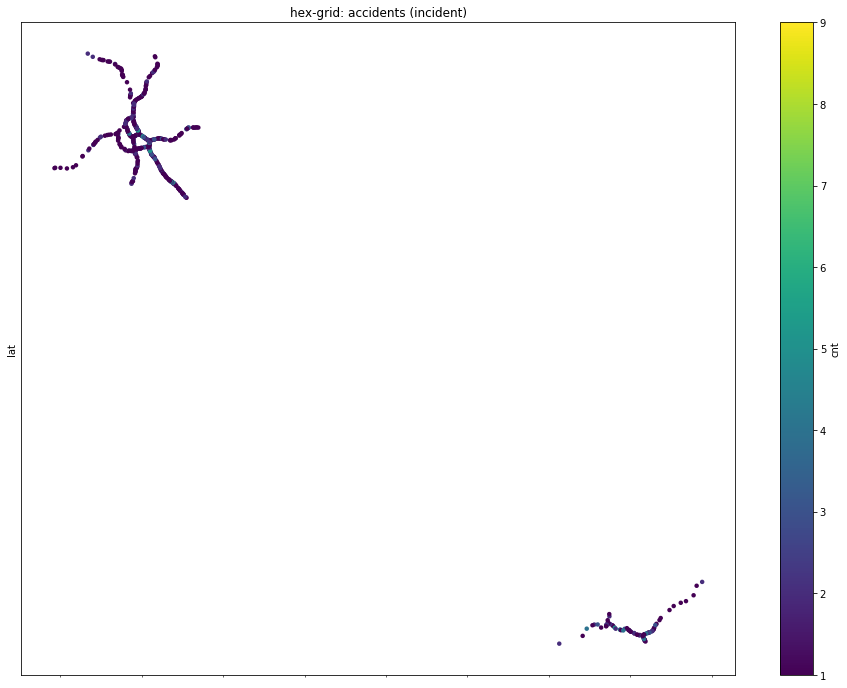

In [13]:
# aggregate the points
incident_g_df = incident_df.groupby(hex_col).size().to_frame('cnt').reset_index()

# find center of hex for visualization
incident_g_df['lat'] = incident_g_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
incident_g_df['lng'] = incident_g_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(incident_g_df, metric_col='cnt', marker='o', figsize=(16, 12))
plt.title('hex-grid: accidents (incident)')

In [9]:
def project_coordinates(lng, lat, radius=None):
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lng)
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )
    center = Point(float(lng), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    if radius is not None:
        buffer = point_transformed.buffer(radius) # in meters
    else:
        buffer = point_transformed
    # Get the polygon with lat lon coordinates
    return transform(aeqd_to_wgs84, buffer)

(-122.4324347576565, 37.77307267839409, -122.43015924234352, 37.77487132160592)
(37.773972, -122.431297)

((37.77295199549506, -122.43161657388478), (37.77345825777557, -122.43097762593246), (37.774128476253445, -122.43118452888069), (37.77429242865195, -122.432030386684), (37.773786163984624, -122.43266933027857), (37.77311594930565, -122.43246242042771))

(-122.43266933027857, 37.77295199549506, -122.43097762593246, 37.77429242865195)

1.2258653546220302e-06



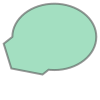

In [19]:
lng, lat = -122.431297, 37.773972 # lon lat for San Francisco

radius = 100  # in m

buffer = project_coordinates(lng, lat, radius)

print(buffer.bounds)

pt = project_coordinates(lng, lat)

print((pt.y, pt.x), end='\n\n')

boundary = h3.h3_to_geo_boundary(h3.geo_to_h3(pt.y, pt.x, 10))

print(boundary, end='\n\n')

grid = Polygon([(x, y) for (y, x) in boundary])

print(grid.bounds, end='\n\n')

print(grid.intersection(buffer).area, end='\n\n')

cascaded_union([grid, buffer])

In [11]:
radius = 100  # in meters

waze_report_uncertainty_regions = []
for lng, lat in tqdm.tqdm(list(zip(report_df.lng, report_df.lat))):
    waze_report_uncertainty_regions.append(project_coordinates(lng, lat, radius))

100%|██████████| 6161/6161 [08:01<00:00, 12.80it/s]


In [592]:
grid_cell_hex_index = np.unique(incident_df[hex_col])

grid_cell_hex_bound = [h3.h3_to_geo_boundary(h) for h in grid_cell_hex_index]

grid_cells_hex = [Polygon([(x, y) for (y, x) in h]) for h in grid_cell_hex_bound]

grid_cell_index = STRtree(grid_cells_hex)

In [593]:
prior_prob = []

for waze_report_region in tqdm.tqdm(waze_report_uncertainty_regions):
    _prior_prob = []
    for grid_cell in grid_cell_index.query(waze_report_region):
        region_intersect = grid_cell.intersection(waze_report_region)
        _prior_prob.append(region_intersect.area / waze_report_region.area)
    prior_prob.append(_prior_prob)

100%|██████████| 6161/6161 [00:03<00:00, 1949.00it/s]


In [600]:
prior_prob

[[0.2120902415987471, 0.0],
 [0.1600910636165149, 0.002890063855137141],
 [0.0007864834248824024, 0.1572661588422793],
 [0.4172593196164302],
 [0.1534969858356344],
 [],
 [0.2316902293336342, 0.3829138454791929],
 [0.0, 0.44047370726952473],
 [0.037461521732639246,
  0.006899303747143378,
  0.4623831849620681,
  0.10153900651569084],
 [],
 [0.4523151678268429, 0.0007937867385050367],
 [],
 [0.4346240442700057, 0.035927503441119474, 0.16080887997638768],
 [0.4346392701000193, 0.03520235084700298, 0.15962575766092948],
 [0.026944075144674774,
  0.2150668110652996,
  0.40959232155106007,
  0.2732539780553932],
 [0.029059037704186205,
  0.25895315611874103,
  0.36707958190677,
  0.28549730028468584,
  0.046592691369967555],
 [0.340896061049645, 0.32154842372933856, 0.003884382004367754],
 [0.2772331701985719, 0.3768934230473619, 0.0],
 [0.0, 0.27250413093330883],
 [0.0, 0.44047370726952473],
 [0.037461521732639246,
  0.006899303747143378,
  0.4623831849620681,
  0.10153900651569084],
 [0.2